<a href="https://colab.research.google.com/github/NickLeenders/Reproduce_BC_Learning/blob/master/RP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproduction by using Pytorch

To reproduce the results of the paper 'Between-class Learning for Image Classification' the code is made available by the authors. However, this code is written in python 2 with a very early version of the Chainer library. Since we had to work on Google Colabs in order to make use of GPU computing this old versions did not work anymore. Therefore, we decided to approach the reproduction in two ways:

1. By building our own version in Pytorch which is done in this Google Colab
2. Update the original code from the authors by making it compatible with python 3 and the newest version of Chainer. To keep the structure of the code intact it was modified offline whereafter is loaded into a Google Colab which can be found in the github repository at the end of this section. Furthermore, an effort is made to change as little as possible since the goal is to reproduce. The (offline) code can be found in the following Github repository: https://github.com/tjsgertsen/Chainer_repro.git

First thing to do is mounting your google drive in order to save results:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Imports
import time
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import torch.optim as optim
import random
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torchvision.models as models
from os import listdir
from os.path import isfile, join

print('Imports complete')

Imports complete


# ResNet Architecture

In the following block of code the ResNet architecture is built. It consists of three building blocks, structured by classes, namely the BasisBlock, the BottleNeck and the ResNet itself which combines everything together.

In [0]:
# ResNet define
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

print('ResNet loaded')




ResNet loaded


# ConvNet Architecture
In the following block of code the 11-Layer CNN called 'ConvNet' in this code is built. Every convolutional layer has batch normilization and a ReLU applied. The neural network consist of 8 convolutional and 3 linear layers.

In [0]:
# Network architecture

class ConvBNReLu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        super(ConvBNReLu, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, input):
        return self.main(input)

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class ConvNet(nn.Module):
    def __init__(self, n_classes):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('conv1', ConvBNReLu(3, 64, 3, padding=1)),
            ('conv2', ConvBNReLu(64, 64, 3, padding=1)),
            ('max_pool1', nn.MaxPool2d(2, stride=2, ceil_mode=True)),
            ('conv3', ConvBNReLu(64, 128, 3, padding=1)),
            ('conv4', ConvBNReLu(128, 128, 3, padding=1)),
            ('max_pool2', nn.MaxPool2d(2, stride=2, ceil_mode=True)),
            ('conv5', ConvBNReLu(128, 256, 3, padding=1)),
            ('conv6', ConvBNReLu(256, 256, 3, padding=1)),
            ('conv7', ConvBNReLu(256, 256, 3, padding=1)),
            ('conv8', ConvBNReLu(256, 256, 3, padding=1)),
            ('max_pool3', nn.MaxPool2d(2, stride=2, ceil_mode=True)),
            ('flatten', Flatten()),
            ('fc4', nn.Linear(in_features=256 * 4 * 4, out_features=1024)),
            ('relu5', nn.ReLU()),
            ('dropout5', nn.Dropout()),
            ('fc5', nn.Linear(1024, 1024)),
            ('relu6', nn.ReLU()),
            ('dropout6', nn.Dropout()),
            ('fc6', nn.Linear(1024, n_classes))
            ]))

    def forward(self, inp):
        return self.model(inp)


# Mixing functions
The mixing functions are defined in the code below. First the general mixing functions for 2 or 3 different images is defined and below that the mixing methods are defined. By changing the parameters 'mixtype' another mixing method can be chosen.



In [0]:
mixtype = 2

def mix(image1, image2, label1, label2, optplus, train):


    # Mix two images
    r = np.array(random.random())
    if optplus:
        g1 = np.std(image1)
        g2 = np.std(image2)
        mu1 = 0
        mu2 = 0
        p = 1.0 / (1 + g1 / g2 * (1 - r) / r)
        image = (((image1 - mu1) * p + (image2 - mu2) * (1 - p)) / np.sqrt(p ** 2 + (1 - p) ** 2)).astype(np.float32)
    else:
        image = (image1 * r + image2 * (1 - r)).astype(np.float32)

    # Mix two labels
    eye = np.eye(nClasses)
    label = (eye[label1] * r + eye[label2] * (1 - r))

    
    image = torch.from_numpy(image).float().to(device)
    label = torch.from_numpy(label).float().to(device)

    return image, label

def mix2(image1, image2, image3, label1, label2, label3, optplus, train):


    # Mix three images
    r1 = np.array(random.random())
    r2 = np.array(random.random())

    image = image1 * (r1 + r2) / 2 + image2 * (1 - r1) / 2 + image3 * (1 - r2) / 2

    # Mix three labels
    eye = np.eye(nClasses)
    label = (eye[label1] * (r1 + r2) / 2 + eye[label2] * (1 - r1) / 2 + eye[label3] * (1 - r2) / 2)

    image = torch.from_numpy(image).float().to(device)
    label = torch.from_numpy(label).float().to(device)

    return image, label

# Ablation analysis of number of mixed classes
Reproducing the ablation analysis of number of mixed classes in table 4 of the paper is done by mixing the image which is given as input by the batch with randomly selected images from the same batch. Depending on the mix type (N in the paper) the images with certain classes are filtered out of the batch to comply with the mix type.

**mixing_method_1**
Represents N=1 which means two images of the same class are mixed.

**mixing_method_2**
Represents N=1 or N=2. Meaning that two images are mixed where it is allowed that they are from the same class.

**mixing_method_3**
Represents N=2, so two images are mixed which always have a different class.

**mixing_method_4**
Represents N=2 or N=3. Mixing two or three images from different classes with a probability of 50%.

**mixing_method_5**
Represents N=3. This mixes three images always from a different class.

In [0]:
def mixing_method_1(data):
  inputs = [] # clear input
  labels = [] # clear labels
  images_cifar, labels_cifar = data
  images_cifar = images_cifar.numpy()
  labels_cifar = labels_cifar.numpy()

  for j in range(0, len(images_cifar[:,0,0,0])):
    # remove image1 from subdataset
    subdata_ic = np.concatenate((images_cifar[:j,:,:,:],images_cifar[j+1:,:,:,:]), axis = 0)
    subdata_lc = np.concatenate((labels_cifar[:j],labels_cifar[j+1:]), axis = 0)
    # get subdataset with same labels as image1
    subdata_ic = subdata_ic[subdata_lc[:]==labels_cifar[j],:,:,:]
    subdata_lc = subdata_lc[subdata_lc[:]==labels_cifar[j]]
    if len(subdata_ic[:,0,0,0])==0:
        break
    else:
        # pick a random image from the subdataset to get image2
        randim = np.random.randint(0,len(subdata_ic[:,0,0,0]))
        # mix images
        images_mix, labels_mix = mix(images_cifar[j,:,:,:], subdata_ic[randim,:,:,:], labels_cifar[j], subdata_lc[randim], optplus, 
                                      True)
        inputs.append(images_mix)
        labels.append(labels_mix)
  
  return inputs, labels

def mixing_method_2(data):
  inputs = [] # clear input
  labels = [] # clear labels
  images_cifar, labels_cifar = data
  images_cifar = images_cifar.numpy()
  labels_cifar = labels_cifar.numpy()

  for j in range(0, len(images_cifar[:,0,0,0])):
    # remove image1 from subdataset
    subdata_ic = np.concatenate((images_cifar[:j,:,:,:],images_cifar[j+1:,:,:,:]), axis = 0)
    subdata_lc = np.concatenate((labels_cifar[:j],labels_cifar[j+1:]), axis = 0)
    # pick a random image from the subdataset to get image2
    randim = np.random.randint(0,len(subdata_ic[:,0,0,0]))
    # mix images
    images_mix, labels_mix = mix(images_cifar[j,:,:,:], subdata_ic[randim,:,:,:], labels_cifar[j], subdata_lc[randim], optplus, 
                                    True)
    inputs.append(images_mix)
    labels.append(labels_mix)
  return inputs, labels

def mixing_method_3(data):
  inputs = [] # clear input
  labels = [] # clear labels
  images_cifar, labels_cifar = data
  images_cifar = images_cifar.numpy()
  labels_cifar = labels_cifar.numpy()

  for j in range(0, len(images_cifar[:,0,0,0])):
    # remove image1 from subdataset
    subdata_ic = np.concatenate((images_cifar[:j,:,:,:],images_cifar[j+1:,:,:,:]), axis = 0)
    subdata_lc = np.concatenate((labels_cifar[:j],labels_cifar[j+1:]), axis = 0)
    # get subdataset with different labels than image1
    subdata_ic = subdata_ic[subdata_lc[:]!=labels_cifar[j],:,:,:]
    subdata_lc = subdata_lc[subdata_lc[:]!=labels_cifar[j]]
    # pick a random image from the subdataset to get image2
    randim = np.random.randint(0,len(subdata_ic[:,0,0,0]))
    # mix images
    images_mix, labels_mix = mix(images_cifar[j,:,:,:], subdata_ic[randim,:,:,:], labels_cifar[j], subdata_lc[randim], optplus, 
                                    True)
    inputs.append(images_mix)
    labels.append(labels_mix)
  return inputs, labels

def mixing_method_4(data):
  inputs = [] # clear input
  labels = [] # clear labels
  images_cifar, labels_cifar = data
  images_cifar = images_cifar.numpy()
  labels_cifar = labels_cifar.numpy()

  for j in range(0, len(images_cifar[:,0,0,0])):
    randu = np.random.random()
    if randu < 0.5:
        # remove image1 from subdataset
        subdata_ic = np.concatenate((images_cifar[:j,:,:,:],images_cifar[j+1:,:,:,:]), axis = 0)
        subdata_lc = np.concatenate((labels_cifar[:j],labels_cifar[j+1:]), axis = 0)
        # get subdataset with different labels than image1
        subdata_ic = subdata_ic[subdata_lc[:] != labels_cifar[j], :, :, :]
        subdata_lc = subdata_lc[subdata_lc[:] != labels_cifar[j]]
        # pick a random image from the subdataset to get image2
        randim = np.random.randint(0, len(subdata_ic[:, 0, 0, 0]))
        # mix images
        images_mix, labels_mix = mix(images_cifar[j, :, :, :], subdata_ic[randim, :, :, :], labels_cifar[j],
                                      subdata_lc[randim], optplus,
                                      True)
        inputs.append(images_mix)
        labels.append(labels_mix)
    else:
        # remove image1 from subdataset
        subdata_ic = np.concatenate((images_cifar[:j,:,:,:],images_cifar[j+1:,:,:,:]), axis = 0)
        subdata_lc = np.concatenate((labels_cifar[:j],labels_cifar[j+1:]), axis = 0)
        # get subdataset with different labels then image1
        subdata_ic = subdata_ic[subdata_lc[:] != labels_cifar[j], :, :, :]
        subdata_lc = subdata_lc[subdata_lc[:] != labels_cifar[j]]
        # pick a random image from the subdataset to get image2
        randim = np.random.randint(0, len(subdata_ic[:, 0, 0, 0]))
        # remove image2 from subdataset2
        subdata_ic2 =  np.concatenate((subdata_ic[:randim,:,:,:],subdata_ic[randim+1:,:,:,:]), axis = 0)
        subdata_lc2 = np.concatenate((subdata_lc[:randim],subdata_lc[randim+1:]), axis = 0)
        # get subdataset2 with different labels then image1 and image2
        subdata_ic2 = subdata_ic2[subdata_lc2[:] != subdata_lc[randim], :, :, :]
        subdata_lc2 = subdata_lc2[subdata_lc2[:] != subdata_lc[randim]]
        # pick a random image fom the subdataset2 to get image3
        randim2 = np.random.randint(0, len(subdata_ic2[:, 0, 0, 0]))

        # mix images
        images_mix, labels_mix = mix2(images_cifar[j, :, :, :], subdata_ic[randim, :, :, :],
                                      subdata_ic2[randim2, :, :, :],
                                      labels_cifar[j], subdata_lc[randim], subdata_lc2[randim2], optplus, True)

        inputs.append(images_mix)
        labels.append(labels_mix)
  return inputs, labels

def mixing_method_5(data):
  inputs = [] # clear input
  labels = [] # clear labels
  images_cifar, labels_cifar = data
  images_cifar = images_cifar.numpy()
  labels_cifar = labels_cifar.numpy()

  for j in range(0, len(images_cifar[:,0,0,0])):
    # remove image1 from subdataset
    subdata_ic = np.concatenate((images_cifar[:j,:,:,:],images_cifar[j+1:,:,:,:]), axis = 0)
    subdata_lc = np.concatenate((labels_cifar[:j],labels_cifar[j+1:]), axis = 0)
    # get subdataset with different labels then image1
    subdata_ic = subdata_ic[subdata_lc[:] != labels_cifar[j], :, :, :]
    subdata_lc = subdata_lc[subdata_lc[:] != labels_cifar[j]]
    # pick a random image from the subdataset to get image2
    randim = np.random.randint(0, len(subdata_ic[:, 0, 0, 0]))
    # remove image2 from subdataset2
    subdata_ic2 =  np.concatenate((subdata_ic[:randim,:,:,:],subdata_ic[randim+1:,:,:,:]), axis = 0)
    subdata_lc2 = np.concatenate((subdata_lc[:randim],subdata_lc[randim+1:]), axis = 0)
    # get subdataset2 with different labels then image1 and image2
    subdata_ic2 = subdata_ic2[subdata_lc2[:] != subdata_lc[randim], :, :, :]
    subdata_lc2 = subdata_lc2[subdata_lc2[:] != subdata_lc[randim]]
    # pick a random image fom the subdataset2 to get image3
    randim2 = np.random.randint(0, len(subdata_ic2[:, 0, 0, 0]))

    # mix images
    images_mix, labels_mix = mix2(images_cifar[j, :, :, :], subdata_ic[randim, :, :, :],
                                  subdata_ic2[randim2, :, :, :],
                                  labels_cifar[j], subdata_lc[randim], subdata_lc2[randim2], optplus, True)

    inputs.append(images_mix)
    labels.append(labels_mix)
  return inputs, labels

if mixtype == 1:
  mixing_method = mixing_method_1
  print('N = 1')
elif mixtype == 2:
  mixing_method = mixing_method_2
  print('N = 1 or 2')
elif mixtype == 3:
  mixing_method = mixing_method_3
  print('N = 2')
elif mixtype == 4:
  mixing_method = mixing_method_4
  print('N = 2 or 3')
elif mixtype == 5:
  mixing_method = mixing_method_5
  print('N = 3')
  

N = 1 or 2


# Data-sets
The datasets are downloaded below. In this block you can switch between BC and BC+ by changing the 'optplus' parameter. Data augmentation for training can also be toggled by changing the 'data_augmentation' parameter.


In [0]:
# Functions and database download

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




def get_test_error(net, testloader):
  correct = 0
  total = 0
  net.eval()
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          test_error = 100 - 100 * correct / total
  return test_error

def get_training_error(net, trainloader):
  correct = 0
  total = 0
  net.eval()
  with torch.no_grad():
      for data in trainloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          train_error = 100 - 100 * correct / total
  return train_error

# Getting images

optplus = True # BC or BC+ 

data_augmentation = True

drive_path = '/content/drive/My Drive/CS4240 - Deep Learning/Reproducibility project/Results/'

batchsize = 128

# Get input and define classes


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

if data_augmentation:
  transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])
else:
  transform_train = transform_test


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

nClasses = len(classes)

dataiter = iter(trainloader)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Training: "Standard" Network
Run this block to train a standard network. The name of the network is defined below and the optimizer parameters a set the ones given in the paper. After training, a pth file is saved as the neural network and a csv file is saved with the progress of the test error per epoch. The parameter 'log_test_error' can be changed to disable testing every epoch.

In [0]:
# Train standard network

net = ConvNet(nClasses) 

if torch.cuda.is_available():
  net.cuda()
  print('Using GPU')
else:
  print('using CPU')

  
criterion = nn.KLDivLoss()
learning_rate = 0.1 # Initial learning rate
nEpoch = 250
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = MultiStepLR(optimizer, milestones=[100,150,200], gamma=0.1) # Decrease learning rate at milestones

name = 'standard_epoch'+str(nEpoch)+net.__class__.__name__+'_no_augmentation'
PATH = '/content/drive/My Drive/CS4240 - Deep Learning/Reproducibility project/Results/' + name + '.pth'

test_error_standard = []
log_test_error = True

for epoch in range(nEpoch):  # Number of epochs (loops over dataset)
  running_loss = 0.0
  net.train()
  for i, data in enumerate(trainloader):
      # get the inputs; data is a list of [inputs, labels]
      
      label = []
      images_cifar, labels_cifar = data

      for j in range(len(labels_cifar)): # Transform labels into one out of K encoding
        label.append((torch.eye(10)[int(labels_cifar[j])]))
      labels = torch.stack(label).to(device)

      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = net(images_cifar.to(device))

      outputs = F.log_softmax(outputs, 1)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step() # Update weights

      running_loss += loss.item()

  
  print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i, running_loss / i))
  running_loss = 0.0

  scheduler.step()
  if log_test_error: # Test network at each epoch and save test error
    test_error = get_test_error(net, testloader)
    test_error_standard.append(test_error)
    print('Test error: %.2f %%' % (
        test_error))


print('Finished Training')

torch.save(net.state_dict(), PATH)
np.savetxt(drive_path+name+'.csv',test_error_standard)

# Training: "BC" or "BC+" Network

Run this block to train a BC or BC+ network. The name of the network is defined below and the optimizer parameters a set the ones given in the paper. After training, a pth file is saved as the neural network and a csv file is saved with the progress of the test error per epoch. The parameter 'log_test_error' can be changed to disable testing every epoch. The parameters 'optplus' should be changed to distinguish between a BC and BC+ network.

In [0]:
# Train BC or BC+ network

net = ConvNet(nClasses) 

if torch.cuda.is_available():
  net.cuda()
  print('Using GPU')
else:
  print('using CPU')

criterion = nn.KLDivLoss()
learning_rate = 0.1 # Initial learning rate
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = MultiStepLR(optimizer, milestones=[100,150,200], gamma=0.1) # Decrease learning rate at milestones
test_error_bc = []
log_test_error = True
nEpoch = 250
if optplus:
    name = 'BCplus_epoch'+str(nEpoch)+net.__class__.__name__+'_n4'
else:
    name = 'BC_epoch'+str(nEpoch)+net.__class__.__name__+'_trial4'
PATH = drive_path + name + '.pth'




for epoch in range(nEpoch):  # Number of epochs (loops over dataset)
  running_loss = 0.0
  net.train()
  for i, data in enumerate(trainloader):

    inputs, labels = mixing_method(data)


    inputs = torch.stack(inputs) # stack tensors
    labels = torch.stack(labels)
    # time2 = time.time()
    # print('mixing took %.2f s' % (time2-time1))
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    outputs = F.log_softmax(outputs, 1)
    loss = criterion(outputs, labels) # calculate loss
    loss.backward() # backprop
    optimizer.step() # update weights

    # print statistics every 200 loops
    running_loss += loss.item()

  print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i, running_loss / i))
  running_loss = 0.0
  scheduler.step()
  if log_test_error: # Test network at each epoch and save test error
    test_error = get_test_error(net, testloader)
    print('Test error: %.2f %%' % (
        test_error))
    test_error_bc.append(test_error)


print('Finished Training')

torch.save(net.state_dict(), PATH)
np.savetxt(drive_path+name+'.csv',test_error_bc)

Using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


[1,   390] loss: 0.148
Test error: 51.18 %


KeyboardInterrupt: ignored

# Testing
Below the generated neural networks can be tested. In the first block, the logged test errors can be plotted for standard, BC and BC+. The blocks below are to generate the results for table 2, 3 and 4 in the paper.

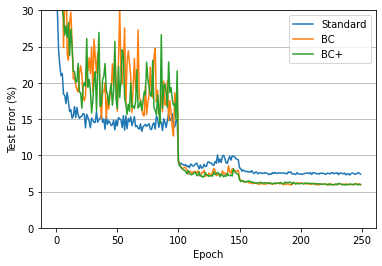

In [0]:
# Plot training error
import matplotlib.pyplot as plt
nEpoch = 250
net = ConvNet(nClasses)
test_error_standard = np.loadtxt(drive_path+'standard_epoch'+str(nEpoch)+net.__class__.__name__+'.csv')
test_error_bc = np.loadtxt(drive_path+'BC_epoch'+str(nEpoch)+net.__class__.__name__+'_trial4'+'.csv')
test_error_bcplus = np.loadtxt(drive_path+'BCplus_epoch'+str(nEpoch)+net.__class__.__name__+'_trial10'+'.csv')

plt.plot(np.arange(nEpoch),np.array(test_error_standard))
plt.plot(np.arange(nEpoch),np.array(test_error_bc))
plt.plot(np.arange(nEpoch),np.array(test_error_bcplus))
plt.ylim([0,30])
plt.xlabel('Epoch')
plt.ylabel('Test Error (%)')
plt.legend((['Standard','BC','BC+']))
axes = plt.gca()
axes.yaxis.grid()
plt.savefig(drive_path+'test_error_250')

plt.show()

In [0]:
# Test the accuracy for 10000 test images

net = ConvNet(10)
net.to(device)

PATH = drive_path+'BCplus_epoch250ConvNet_n1N3.pth'
net.load_state_dict(torch.load(PATH))

test_error = get_test_error(net, testloader)
train_error = get_training_error(net, trainloader)
print('Test error: %.2f %%' % (
  test_error))
print('Training error: %.2f %%' % (
  train_error))

Test error: 5.68 %
Training error: 0.22 %


In [0]:
# Create Table 2

net = ConvNet(10)
net.to(device)
net.eval()

standard_models = [f for f in listdir(drive_path+'Standard/') if isfile(join(drive_path+'Standard/', f))]
standard_errors = np.empty(len(standard_models))
for i, model in enumerate(standard_models):
  path = drive_path+'Standard/'+model
  net.load_state_dict(torch.load(path))
  standard_errors[i] = get_test_error(net, testloader)
print('Standard average (%%): %.2f +/- %.2f (for %d trials)' % (np.average(standard_errors), np.std(standard_errors), len(standard_models)))

bc_models = [f for f in listdir(drive_path+'BC/') if isfile(join(drive_path+'BC/', f))]
bc_errors = np.empty(len(bc_models))
for i, model in enumerate(bc_models):
  path = drive_path+'BC/'+model
  net.load_state_dict(torch.load(path))
  bc_errors[i] = get_test_error(net, testloader)
print('BC average (%%): %.2f  +/- %.2f (for %d trials)' % (np.average(bc_errors), np.std(bc_errors), len(bc_models)))

bcplus_models = [f for f in listdir(drive_path+'BCplus/') if isfile(join(drive_path+'BCplus/', f))]
bcplus_errors = np.empty(len(bcplus_models))
for i, model in enumerate(bcplus_models):
  path = drive_path+'BCplus/'+model
  net.load_state_dict(torch.load(path))
  bcplus_errors[i] = get_test_error(net, testloader)
print('BC+ average (%%): %.2f  +/- %.2f (for %d trials)' % (np.average(bcplus_errors), np.std(bcplus_errors), len(bcplus_models)))



Standard average (%): 7.04 +/- 0.06 (for 5 trials)
BC average (%): 5.92  +/- 0.05 (for 4 trials)
BC+ average (%): 5.85  +/- 0.12 (for 5 trials)


In [0]:
# Create Table 3
net.eval()

augment_models = ['standard_epoch250ConvNet_withoutDataAugmentation.pth','BC_epoch250ConvNet_BC_withoutDataAugmentation.pth']
augment_errors = np.empty(len(augment_models))

for i, model in enumerate(augment_models):
  path = drive_path+'Augmentation/'+model
  net.load_state_dict(torch.load(path))
  augment_errors[i] = get_test_error(net, testloader)

print("""Standard without Data Augmentation: %.2f %% \n
BC without Data Augmentation: %.2f %%
""" % (augment_errors[0], augment_errors[1]))



Standard without Data Augmentation: 10.08 % 

BC without Data Augmentation: 8.33 %



In [0]:
# Create '#mixed classes' in Table 4

net.eval()
ablation_models = ['BC_epoch250ConvNet_n1.pth', 'BC_epoch250ConvNet_n2.pth', 'BC_epoch250ConvNet_n3.pth', 'BC_epoch250ConvNet_n4.pth', 'BC_epoch250ConvNet_n5.pth']
ablation_errors = np.empty(len(ablation_models))

for i, model in enumerate(ablation_models):
  path = drive_path+'Ablation/'+model
  net.load_state_dict(torch.load(path))
  ablation_errors[i] = get_test_error(net, testloader)

print("""N = 1 : %.2f %% \n
N = 1 or 2: %.2f %% \n
N = 2: %.2f %% \n
N = 2 or 3: %.2f %% \n
N = 3: %.2f %%""" % (ablation_errors[0], ablation_errors[1], ablation_errors[2], ablation_errors[3], ablation_errors[4]) )

N = 1 : 5.93 % 

N = 1 or 2: 5.88 % 

N = 2: 5.68 % 

N = 2 or 3: 5.54 % 

N = 3: 6.05 %
